In [1]:
import numpy as np
from pyquil import get_qc, Program

In [20]:
from pyquil.gates import H, MEASURE, RESET, X, I
from pyquil.paulis import exponential_map, PauliSum, sX, sZ

def maxcut_qaoa_program(num_nodes, edge_list, delta, U, omega, betas, gammas) -> Program:
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    cost_ham = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    driver_ham = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)

    p = Program(RESET())
    ro = p.declare('ro', 'BIT', len(nodes))

    # p.inst(H(qubit) for qubit in list(nodes))
    # p.inst(exponential_map(term)(gamma) for term in cost_ham)
    # p.inst(exponential_map(term)(beta) for term in driver_ham)
    
    p += [exponentiate_commuting_pauli_sum(cost_ham)(g) + exponentiate_commuting_pauli_sum(driver_ham)(b) 
                for g, b in zip(gammas, betas)]

    #p.inst(MEASURE(qubit, ro[idx]) for idx, qubit in enumerate(list(nodes)))
    return p

In [63]:
import itertools
from tqdm import tqdm
from pyquil.api import QPU, QuantumComputer

def run_maxcut_qaoa_landscape(qc: QuantumComputer, num_nodes, edge_list, delta, U, omega, width: int,
                              shots: int = 1000) -> np.ndarray:
   
    costs = []
    angle_range = np.linspace(0, np.pi, width)
    landscape = list(itertools.product(angle_range, angle_range, angle_range, angle_range))
    for lst in tqdm(landscape):
        print(lst)
        betas = lst[:2]
        gammas = lst[2:]
        #qc.reset()
        # graph = generate_ising_graph(edges, seed)
        p = mis_ansatz(betas, gammas)
        #mean = 0
        #for _ in range(shots):
            #mean+= .expectation(prep_prog = p, pauli_terms = h_cost)
        p.wrap_in_numshots_loop(shots)
        binary = qc.compile(p) if isinstance(qc.qam, QPU) else p
        bitstrings = qvm.run(binary)
        print(bitstrings)
        energy = np.mean([bit_energy(b, h_cost) for b in bitstrings])
        costs.append(energy)
        #print(energy)
        
    return costs

In [22]:
# qpu = get_qc('Aspen-3-3Q-B')  # edit as necessary
qvm = get_qc('6q-qvm')  # edit as necessary

In [62]:
from pyquil.api import WavefunctionSimulator

def bit_energy(bitstring, h_cost):
    size = len(bitstring)
    pq = Program()
    for i in range(size):
        if bitstring[i] == 0:
            pq += Program(I(i))
        elif bitstring[i] == 1:
            pq += Program(X(i))
    return np.real(WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost))

In [6]:
import matplotlib.pyplot as plt
from typing import List, Tuple

def plot_landscape(landscape: np.ndarray, *, device: str, edges: List[Tuple[int, int]],
                   width: int, shots: int):
    max_x, max_y = (np.argmax(landscape) % width, np.argmax(landscape) // width)
    plt.imshow(landscape, extent=[0, np.pi, np.pi, 0])
    plt.plot((max_x + 0.5) * np.pi / width, (max_y + 0.5) * np.pi / width, 'ro')
    plt.colorbar()
    plt.xlabel('gamma (radians)')
    plt.ylabel('beta (radians)')
    plt.title(f'Max-Cut QAOA Landscape\n{device}\n{edges}\nwidth = {width} shots = {shots}')
    plt.show()




  0%|          | 0/81 [00:00<?, ?it/s]


  2%|▏         | 2/81 [00:00<00:07, 11.18it/s]

(0.0, 0.0, 0.0, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(0.0, 0.0, 0.0, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(0.0, 0.0, 0.0, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]





  5%|▍         | 4/81 [00:00<00:06, 11.39it/s]

(0.0, 0.0, 1.5707963267948966, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(0.0, 0.0, 1.5707963267948966, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(0.0, 0.0, 1.5707963267948966, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]





  7%|▋         | 6/81 [00:00<00:06, 11.49it/s]


 10%|▉         | 8/81 [00:00<00:06, 11.59it/s]

(0.0, 0.0, 3.141592653589793, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(0.0, 0.0, 3.141592653589793, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(0.0, 0.0, 3.141592653589793, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]





 12%|█▏        | 10/81 [00:00<00:06, 11.65it/s]

(0.0, 1.5707963267948966, 0.0, 0.0)
[[0 1 0 0 0]
 [1 0 0 1 1]
 [0 1 0 0 0]
 [0 0 1 1 1]
 [1 1 0 1 1]
 [1 0 1 0 0]
 [0 0 1 0 0]
 [1 1 0 0 1]
 [1 0 0 0 1]
 [1 0 0 0 0]]
(0.0, 1.5707963267948966, 0.0, 1.5707963267948966)
[[1 0 0 0 0]
 [1 0 1 0 0]
 [0 1 1 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
(0.0, 1.5707963267948966, 0.0, 3.141592653589793)
[[0 0 1 0 1]
 [0 1 0 0 0]
 [0 1 1 0 1]
 [1 0 0 1 0]
 [1 1 0 1 0]
 [0 0 1 0 1]
 [1 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 1]
 [1 0 1 1 1]]





 15%|█▍        | 12/81 [00:01<00:05, 11.69it/s]


 17%|█▋        | 14/81 [00:01<00:05, 11.50it/s]

(0.0, 1.5707963267948966, 1.5707963267948966, 0.0)
[[0 0 0 1 0]
 [1 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 1]
 [1 0 0 0 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 0 0]
 [0 1 1 0 1]
 [0 1 1 1 1]]
(0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966)
[[1 1 1 1 0]
 [1 1 0 1 1]
 [0 0 1 1 0]
 [1 1 0 1 1]
 [1 1 0 0 1]
 [1 1 1 1 0]
 [0 1 1 0 1]
 [1 0 1 0 0]
 [1 1 0 1 1]
 [1 0 0 1 1]]
(0.0, 1.5707963267948966, 1.5707963267948966, 3.141592653589793)
[[1 1 0 0 1]
 [0 0 0 1 1]
 [0 0 0 1 0]
 [0 1 1 1 0]
 [1 1 1 0 0]
 [1 0 0 1 0]
 [1 1 1 0 0]
 [1 1 0 0 1]
 [0 0 1 0 1]
 [0 1 1 0 1]]





 20%|█▉        | 16/81 [00:01<00:05, 11.51it/s]

(0.0, 1.5707963267948966, 3.141592653589793, 0.0)
[[0 1 0 1 0]
 [1 1 1 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 1 0]
 [0 1 0 0 0]
 [1 0 1 0 1]
 [0 1 0 0 0]
 [1 1 0 1 1]
 [0 1 1 1 1]]
(0.0, 1.5707963267948966, 3.141592653589793, 1.5707963267948966)
[[1 1 0 1 0]
 [0 1 1 1 0]
 [0 1 1 0 0]
 [0 0 1 1 1]
 [1 1 1 1 0]
 [1 0 0 0 0]
 [0 0 1 0 1]
 [1 1 0 1 0]
 [0 0 1 1 0]
 [1 1 1 1 1]]
(0.0, 1.5707963267948966, 3.141592653589793, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 0 0]
 [0 0 0 0 1]
 [1 1 0 0 1]
 [1 1 1 0 0]
 [0 0 1 1 0]
 [0 1 0 1 1]
 [0 1 0 1 1]
 [0 0 0 1 0]
 [0 1 1 0 1]]





 22%|██▏       | 18/81 [00:01<00:05, 11.51it/s]


 25%|██▍       | 20/81 [00:01<00:05, 11.49it/s]

(0.0, 3.141592653589793, 0.0, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(0.0, 3.141592653589793, 0.0, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(0.0, 3.141592653589793, 0.0, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]





 27%|██▋       | 22/81 [00:01<00:05, 11.60it/s]

(0.0, 3.141592653589793, 1.5707963267948966, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(0.0, 3.141592653589793, 1.5707963267948966, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(0.0, 3.141592653589793, 1.5707963267948966, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]





 30%|██▉       | 24/81 [00:02<00:04, 11.72it/s]


 32%|███▏      | 26/81 [00:02<00:04, 11.84it/s]

(0.0, 3.141592653589793, 3.141592653589793, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(0.0, 3.141592653589793, 3.141592653589793, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(0.0, 3.141592653589793, 3.141592653589793, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]





 35%|███▍      | 28/81 [00:02<00:04, 11.75it/s]

(1.5707963267948966, 0.0, 0.0, 0.0)
[[0 0 1 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [1 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [1 1 1 1 0]
 [0 1 1 0 1]
 [0 0 1 1 0]]
(1.5707963267948966, 0.0, 0.0, 1.5707963267948966)
[[1 1 0 0 1]
 [0 0 0 0 0]
 [1 0 0 1 0]
 [0 1 1 0 1]
 [0 0 1 0 1]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 1]]
(1.5707963267948966, 0.0, 0.0, 3.141592653589793)
[[1 0 0 1 1]
 [0 0 1 0 1]
 [1 0 0 1 0]
 [0 1 0 1 1]
 [1 0 0 1 1]
 [0 1 1 0 0]
 [1 1 0 0 1]
 [0 0 1 0 0]
 [0 0 1 1 1]
 [1 0 0 0 0]]





 37%|███▋      | 30/81 [00:02<00:04, 11.72it/s]


 40%|███▉      | 32/81 [00:02<00:04, 11.82it/s]

(1.5707963267948966, 0.0, 1.5707963267948966, 0.0)
[[0 0 0 0 1]
 [1 0 0 1 1]
 [0 1 1 0 1]
 [1 0 1 0 1]
 [1 0 0 0 0]
 [0 0 1 1 0]
 [0 0 0 0 1]
 [0 1 0 1 1]
 [1 0 1 0 1]
 [1 1 0 1 1]]
(1.5707963267948966, 0.0, 1.5707963267948966, 1.5707963267948966)
[[0 1 0 0 1]
 [0 1 0 1 1]
 [0 1 1 1 0]
 [1 0 0 0 0]
 [0 1 1 0 0]
 [1 0 0 0 0]
 [1 0 1 0 1]
 [0 1 1 1 0]
 [1 0 1 1 0]
 [1 1 1 0 1]]
(1.5707963267948966, 0.0, 1.5707963267948966, 3.141592653589793)
[[1 1 0 0 1]
 [1 0 0 1 1]
 [1 0 0 1 0]
 [1 0 0 0 1]
 [1 0 1 1 1]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [1 0 0 1 1]
 [1 1 0 0 0]
 [1 0 1 0 1]]





 42%|████▏     | 34/81 [00:02<00:03, 11.82it/s]

(1.5707963267948966, 0.0, 3.141592653589793, 0.0)
[[1 1 1 1 1]
 [1 1 1 0 1]
 [1 0 0 0 1]
 [0 1 1 0 1]
 [0 1 1 0 1]
 [0 1 1 0 1]
 [0 1 1 1 1]
 [1 1 0 1 1]
 [1 0 0 0 0]
 [0 0 0 0 1]]
(1.5707963267948966, 0.0, 3.141592653589793, 1.5707963267948966)
[[1 0 0 1 0]
 [1 1 0 0 1]
 [1 0 1 0 1]
 [1 0 0 1 0]
 [0 1 0 1 1]
 [0 0 1 1 1]
 [0 1 0 1 0]
 [1 0 1 0 1]
 [1 1 0 1 0]
 [0 0 0 1 1]]
(1.5707963267948966, 0.0, 3.141592653589793, 3.141592653589793)
[[1 0 0 1 0]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [0 0 1 0 1]
 [0 0 0 1 1]
 [1 1 0 1 0]
 [1 0 1 0 1]
 [1 0 1 0 0]
 [1 0 1 1 0]
 [1 0 0 0 0]]





 44%|████▍     | 36/81 [00:03<00:03, 11.86it/s]


 47%|████▋     | 38/81 [00:03<00:03, 11.83it/s]

(1.5707963267948966, 1.5707963267948966, 0.0, 0.0)
[[1 1 0 1 1]
 [1 1 0 1 1]
 [0 0 1 0 1]
 [0 0 0 0 0]
 [1 0 1 0 1]
 [0 1 1 0 1]
 [0 0 0 0 0]
 [1 1 0 1 0]
 [1 0 0 1 0]
 [0 0 1 0 1]]
(1.5707963267948966, 1.5707963267948966, 0.0, 1.5707963267948966)
[[0 0 1 0 0]
 [1 1 1 1 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 1 1 1 1]
 [0 0 0 0 1]
 [0 1 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 1]]
(1.5707963267948966, 1.5707963267948966, 0.0, 3.141592653589793)
[[1 0 0 1 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [1 1 1 1 0]
 [1 1 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [1 1 0 0 1]
 [1 1 1 1 0]]





 49%|████▉     | 40/81 [00:03<00:03, 11.87it/s]

(1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0)
[[0 1 0 1 0]
 [1 1 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 0 0]
 [1 1 1 1 1]
 [0 1 0 0 0]
 [1 1 1 0 1]
 [1 1 0 1 1]
 [0 1 0 1 0]]
(1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966)
[[0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 0 1]
 [1 1 1 1 1]
 [0 1 1 1 1]
 [0 1 0 1 1]
 [1 1 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]
(1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 3.141592653589793)
[[1 1 0 0 0]
 [0 0 0 0 0]
 [0 0 1 1 1]
 [0 0 0 0 0]
 [1 1 0 1 0]
 [1 1 0 1 0]
 [0 0 1 0 0]
 [0 1 0 1 0]
 [1 1 1 1 1]
 [1 1 1 0 1]]





 52%|█████▏    | 42/81 [00:03<00:03, 11.87it/s]


 54%|█████▍    | 44/81 [00:03<00:03, 11.83it/s]

(1.5707963267948966, 1.5707963267948966, 3.141592653589793, 0.0)
[[0 0 0 0 1]
 [1 1 0 1 1]
 [0 0 0 0 0]
 [1 0 0 0 1]
 [1 1 1 1 0]
 [1 1 0 1 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 0 1 1]
 [1 1 1 1 0]]
(1.5707963267948966, 1.5707963267948966, 3.141592653589793, 1.5707963267948966)
[[1 1 1 0 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [0 0 1 1 0]
 [0 1 1 1 1]
 [1 1 1 1 0]
 [1 1 0 1 0]
 [0 1 1 1 1]
 [0 0 0 0 1]]
(1.5707963267948966, 1.5707963267948966, 3.141592653589793, 3.141592653589793)
[[0 0 0 0 0]
 [0 1 0 1 0]
 [0 1 0 0 0]
 [0 1 0 1 1]
 [1 0 1 1 1]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [1 0 0 1 0]
 [0 0 1 1 0]
 [0 0 0 0 0]]





 57%|█████▋    | 46/81 [00:03<00:02, 11.86it/s]

(1.5707963267948966, 3.141592653589793, 0.0, 0.0)
[[0 0 1 0 1]
 [1 1 1 1 1]
 [1 0 0 1 0]
 [1 1 1 1 0]
 [1 0 1 1 1]
 [1 1 0 0 0]
 [0 0 0 1 1]
 [0 1 0 1 0]
 [1 0 0 1 1]
 [1 0 0 1 1]]
(1.5707963267948966, 3.141592653589793, 0.0, 1.5707963267948966)
[[1 0 1 0 1]
 [1 1 0 1 0]
 [1 0 1 1 0]
 [1 0 1 1 0]
 [1 0 1 0 1]
 [1 1 1 0 0]
 [1 1 0 0 1]
 [0 1 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 1]]
(1.5707963267948966, 3.141592653589793, 0.0, 3.141592653589793)
[[1 0 0 1 0]
 [1 1 0 0 0]
 [1 0 1 1 1]
 [0 0 1 1 0]
 [1 1 0 1 0]
 [1 1 0 0 1]
 [1 1 0 1 0]
 [0 0 1 0 1]
 [0 1 1 0 0]
 [1 1 1 1 1]]





 59%|█████▉    | 48/81 [00:04<00:02, 11.85it/s]


 62%|██████▏   | 50/81 [00:04<00:02, 11.85it/s]

(1.5707963267948966, 3.141592653589793, 1.5707963267948966, 0.0)
[[0 1 0 0 1]
 [0 1 0 1 1]
 [0 1 1 1 1]
 [1 0 0 0 0]
 [1 1 1 1 0]
 [1 1 1 0 1]
 [1 0 0 1 1]
 [1 1 0 0 1]
 [1 0 0 0 1]
 [1 1 0 1 1]]
(1.5707963267948966, 3.141592653589793, 1.5707963267948966, 1.5707963267948966)
[[1 1 0 1 0]
 [1 0 1 0 1]
 [0 0 1 0 1]
 [1 1 1 0 1]
 [1 0 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 1]
 [1 1 0 0 0]
 [0 0 1 1 0]
 [0 1 0 0 0]]
(1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793)
[[1 1 1 0 1]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [1 1 1 1 0]
 [0 1 1 0 1]
 [0 1 1 1 0]
 [1 1 0 1 1]
 [0 0 0 1 0]
 [0 0 0 1 1]
 [1 0 0 1 0]]





 64%|██████▍   | 52/81 [00:04<00:02, 11.83it/s]

(1.5707963267948966, 3.141592653589793, 3.141592653589793, 0.0)
[[1 0 1 1 1]
 [0 0 1 1 1]
 [0 1 1 1 0]
 [1 1 1 1 0]
 [1 1 0 0 0]
 [1 1 1 1 0]
 [0 0 0 1 1]
 [1 0 0 0 1]
 [1 0 1 1 0]
 [0 0 0 1 1]]
(1.5707963267948966, 3.141592653589793, 3.141592653589793, 1.5707963267948966)
[[0 0 1 1 0]
 [1 0 0 1 0]
 [0 1 1 0 1]
 [0 1 0 1 0]
 [1 1 1 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [1 1 0 1 0]
 [1 1 0 0 0]
 [1 0 0 1 1]]
(1.5707963267948966, 3.141592653589793, 3.141592653589793, 3.141592653589793)
[[0 1 0 1 0]
 [1 0 1 0 1]
 [1 1 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [1 1 0 1 1]
 [0 0 1 0 0]
 [1 1 1 0 0]
 [1 0 1 1 1]
 [1 0 0 1 1]]





 67%|██████▋   | 54/81 [00:04<00:02, 11.77it/s]

(3.141592653589793, 0.0, 0.0, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(3.141592653589793, 0.0, 0.0, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]





 69%|██████▉   | 56/81 [00:04<00:02, 10.85it/s]


 72%|███████▏  | 58/81 [00:04<00:02, 11.17it/s]

(3.141592653589793, 0.0, 0.0, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(3.141592653589793, 0.0, 1.5707963267948966, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(3.141592653589793, 0.0, 1.5707963267948966, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]





 74%|███████▍  | 60/81 [00:05<00:01, 11.36it/s]

(3.141592653589793, 0.0, 1.5707963267948966, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(3.141592653589793, 0.0, 3.141592653589793, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(3.141592653589793, 0.0, 3.141592653589793, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]





 77%|███████▋  | 62/81 [00:05<00:01, 11.45it/s]


 79%|███████▉  | 64/81 [00:05<00:01, 11.52it/s]

(3.141592653589793, 0.0, 3.141592653589793, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
(3.141592653589793, 1.5707963267948966, 0.0, 0.0)
[[0 0 0 1 1]
 [1 0 0 0 0]
 [1 0 1 1 1]
 [0 1 1 0 1]
 [1 0 0 0 1]
 [1 1 0 0 0]
 [1 1 1 0 0]
 [1 0 1 0 0]
 [1 1 0 1 1]
 [1 1 1 0 1]]
(3.141592653589793, 1.5707963267948966, 0.0, 1.5707963267948966)
[[0 1 1 0 1]
 [0 1 0 0 0]
 [0 1 0 1 1]
 [1 1 0 1 1]
 [1 0 1 0 0]
 [0 0 1 1 0]
 [1 1 0 0 0]
 [0 0 1 0 1]
 [1 0 1 0 0]
 [1 1 0 1 0]]





 81%|████████▏ | 66/81 [00:05<00:01, 11.41it/s]

(3.141592653589793, 1.5707963267948966, 0.0, 3.141592653589793)
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [1 0 0 1 0]
 [1 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 0 0]
 [0 0 0 1 1]]
(3.141592653589793, 1.5707963267948966, 1.5707963267948966, 0.0)
[[1 0 1 0 1]
 [1 1 1 0 0]
 [1 0 1 0 0]
 [1 1 0 0 1]
 [1 0 1 0 1]
 [0 0 0 0 0]
 [1 1 1 0 0]
 [0 0 1 1 0]
 [1 1 1 0 0]
 [1 1 1 0 0]]
(3.141592653589793, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 0]
 [0 0 0 1 1]
 [1 1 1 0 1]
 [0 0 0 1 1]
 [1 0 0 1 1]
 [1 0 1 1 0]
 [0 0 1 0 1]
 [0 0 1 0 1]
 [0 0 1 0 1]]





 84%|████████▍ | 68/81 [00:05<00:01, 11.57it/s]


 86%|████████▋ | 70/81 [00:06<00:00, 11.69it/s]

(3.141592653589793, 1.5707963267948966, 1.5707963267948966, 3.141592653589793)
[[0 0 0 1 1]
 [0 0 1 0 0]
 [0 1 1 0 0]
 [0 0 0 1 1]
 [1 1 1 0 1]
 [1 1 1 1 0]
 [0 0 0 0 0]
 [1 1 1 0 1]
 [0 0 1 0 1]
 [1 0 0 1 1]]
(3.141592653589793, 1.5707963267948966, 3.141592653589793, 0.0)
[[0 0 0 1 0]
 [0 0 0 1 1]
 [1 1 1 0 1]
 [1 0 1 0 0]
 [1 0 0 1 1]
 [0 0 0 0 0]
 [0 0 0 1 1]
 [0 0 1 0 0]
 [1 0 0 0 1]
 [1 1 1 0 1]]
(3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966)
[[1 1 0 1 0]
 [0 1 1 1 1]
 [0 0 0 1 1]
 [1 1 1 0 1]
 [1 0 0 0 1]
 [1 1 1 0 0]
 [1 0 0 1 0]
 [0 0 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]





 89%|████████▉ | 72/81 [00:06<00:00, 11.71it/s]

(3.141592653589793, 1.5707963267948966, 3.141592653589793, 3.141592653589793)
[[1 1 0 1 1]
 [0 0 1 1 1]
 [0 1 1 0 1]
 [0 0 0 1 1]
 [1 0 1 1 0]
 [0 0 1 0 1]
 [1 0 0 1 0]
 [0 0 1 1 1]
 [1 1 0 0 0]
 [0 1 1 1 0]]
(3.141592653589793, 3.141592653589793, 0.0, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(3.141592653589793, 3.141592653589793, 0.0, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]





 91%|█████████▏| 74/81 [00:06<00:00, 11.69it/s]


 94%|█████████▍| 76/81 [00:06<00:00, 11.68it/s]

(3.141592653589793, 3.141592653589793, 0.0, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(3.141592653589793, 3.141592653589793, 1.5707963267948966, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(3.141592653589793, 3.141592653589793, 1.5707963267948966, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]





 96%|█████████▋| 78/81 [00:06<00:00, 11.74it/s]

(3.141592653589793, 3.141592653589793, 1.5707963267948966, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(3.141592653589793, 3.141592653589793, 3.141592653589793, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(3.141592653589793, 3.141592653589793, 3.141592653589793, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]





 99%|█████████▉| 80/81 [00:06<00:00, 11.84it/s]


100%|██████████| 81/81 [00:06<00:00, 11.67it/s]

(3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


TypeError: Invalid shape (81,) for image data

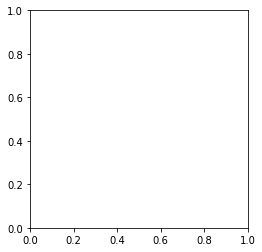

In [67]:
string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5'
elist = elist_from_math(string)

width = 3
shots = 10
num_nodes = 5  # edit as necessary
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, delta, U, omega)

def mis_ansatz(betas, gammas):
    pq = Program()
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    pq.measure_all()
    return pq

#landscape_qpu = run_maxcut_qaoa_landscape(qpu, edges, width, shots, seed)
landscape_qvm = run_maxcut_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
#plot_landscape(landscape_qpu, device=qpu.name, edges=edges, width=width, shots=shots)
plot_landscape(landscape_qvm, device=qvm.name, edges=elist, width=width, shots=shots)

In [68]:
a = np.array(landscape_qvm)

In [69]:
np.sort(a)

array([-0.25, -0.2 , -0.05,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.05,  0.1 ,  0.25,  0.25,  0.3 ,
        0.3 ,  0.35,  0.45,  0.45,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,
        0.65,  0.7 ,  0.7 ,  0.8 ,  0.85,  0.9 ,  0.95,  1.05,  1.1 ,
        1.25,  1.3 ,  1.3 ,  1.35,  1.35,  1.4 ,  1.4 ,  1.45,  1.45,
        1.55,  1.6 ,  1.6 ,  1.7 ,  1.8 ,  1.95,  2.7 ,  3.25,  3.7 ,
        8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,
        8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ])

In [12]:
from pyquil import Program, noise
from pyquil.api import WavefunctionSimulator
from pyquil.gates import H
from pyquil.paulis import sZ, sX, sI, exponentiate_commuting_pauli_sum
from scipy.optimize import minimize

import operator
import matplotlib.pyplot as plt

In [8]:
def elist_from_math(string):
    string = string.replace(',','), (')
    string = string.replace(' <->',',')
    return eval('(' + string + ')')

In [10]:
def get_hamil(num_nodes, edge_list, delta, U, omega):
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

In [ ]:
def mis_ansatz(betas, gammas):
    pq = Program()
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    return pq

In [ ]:
def mis_cost(params):
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    #init_state_prog = Program(RESET())
    #pq = init_state_prog + mis_ansatz(betas, gammas, h_cost, h_driver)
    pq = mis_ansatz(betas, gammas)
    return WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost)

In [ ]:
def run_qaoa_mis(guess):
    result = minimize(mis_cost, x0 = guess, method='Nelder-Mead', options={'disp': True})
    wf_sim = WavefunctionSimulator()
    half = int(len(result['x'])/2)
    pq = mis_ansatz(result['x'][:half],result['x'][half:])
    wavefunction = wf_sim.wavefunction(pq)
    prob_dict = wavefunction.get_outcome_probs() 
    sorted_dict = sorted(prob_dict.items(), key = operator.itemgetter(1))
    return sorted_dict[len(prob_dict)-1]

In [ ]:
# elist = [(1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5),
#           (3, 7), (4, 7), (4, 10), (5, 6), (5, 9), (6, 7), (6, 9), (6, 10), (7, 9), (9, 10)]
#string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 7, 3 <-> 4, 3 <-> 7, 4 <-> 6, 4 <-> 7, 7 <-> 8'

string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5'
elist = elist_from_math(string)

num_nodes = 5
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, 1, 1.5, 0.5)

In [ ]:
%%time
result = run_qaoa_mis([0.5,0.5, 0.5, 0.5])
print(result)

In [ ]:
# correct = '1011010000'
# correct = '10110110'
correct = '10100'
p_vals = []
prob_vals = []
for p in range(1,11):
    params = [0.5] * 2 * p
    result = run_qaoa_mis(params)
    if (result[0] == correct):
        p_vals.append(p)
        prob_vals.append(result[1])
    else:
        print("BAD p value:", p, "with State:", result[0])

In [78]:
p = Program(I(0), I(1))

In [80]:
program = Program(X(0), MEASURE(0, 0))
results = qvm.run(program)

/home/forest/.virtualenvs/venv/lib/python3.6/site-packages/pyquil/gates.py:490: UserWarning: Indexing measurement addresses by integers is deprecated. Replacing this with the MemoryReference ro[i] instead.
  + "Replacing this with the MemoryReference ro[i] instead.")


AssertionError: 

In [90]:
from pyquil.api import QVMConnection
qvm = QVMConnection()
program = Program(X(0), I(1))
program.measure_all()
results = qvm.run(program)

In [91]:
results

[[1, 0]]